In [1]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate


//anaconda/lib/python2.7/site-packages/pyoperators/utils/misc.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import cythonutils as cu
//anaconda/lib/python2.7/site-packages/pyfftw/__init__.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .pyfftw import (
//anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _sphtools as _sphtools


importing qubicpack without pystudio


//anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from . import _sphtools as _sphtools
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:48: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._pixelfunc import ringinfo, pix2ring
//anaconda/lib/python2.7/site-packages/healpy/__init__.py:48: RuntimeWarning: numpy.ufunc size changed, may indi

## Dataset

Get the directories corresponding to the day we consider:

In [299]:
day = '2019-02-22'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.sort(glob.glob(data_dir+'/*'))
print dirs
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
print labels

['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.11.38__Scan1'
 '/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2']
['Scan1', 'Scan2']


## Select one directory to start with

In [300]:
thedir = dirs[1]

## Reading Data 

In [273]:
AsicNum = 1
a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

## Reading Azimuth data

setting pps interval to 1 second
(52939,)
(52939,)


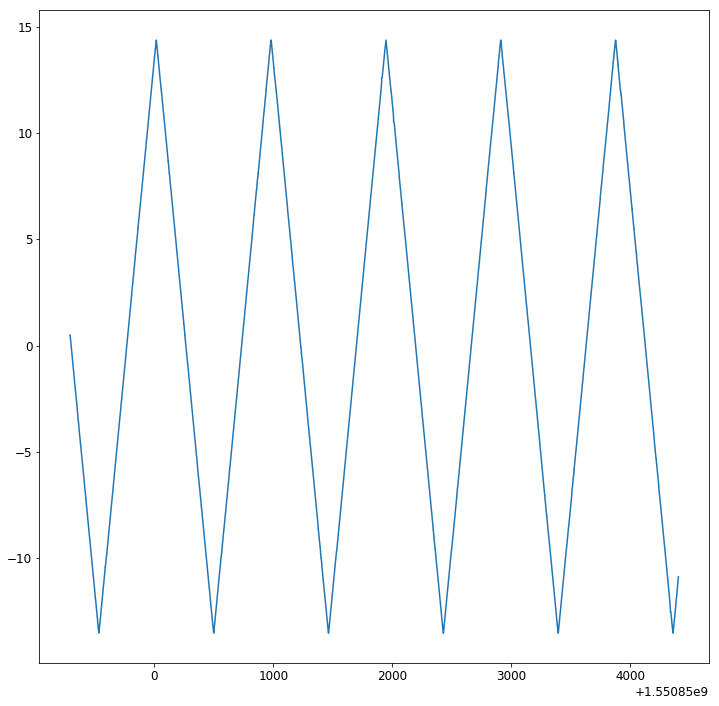

In [280]:
pps=a.pps(hk='INTERN_HK')
gps=a.gps(hk='INTERN_HK')
t_az = a.pps2date(pps,gps)
az = a.hk['INTERN_HK']['Platform-Azimut']
az = (az-2.**15)/(2.**16)*360

print t_az.shape
print az.shape
plot(t_az, az)

## Reading data for a given asic and pixel

setting pps interval to 1 second


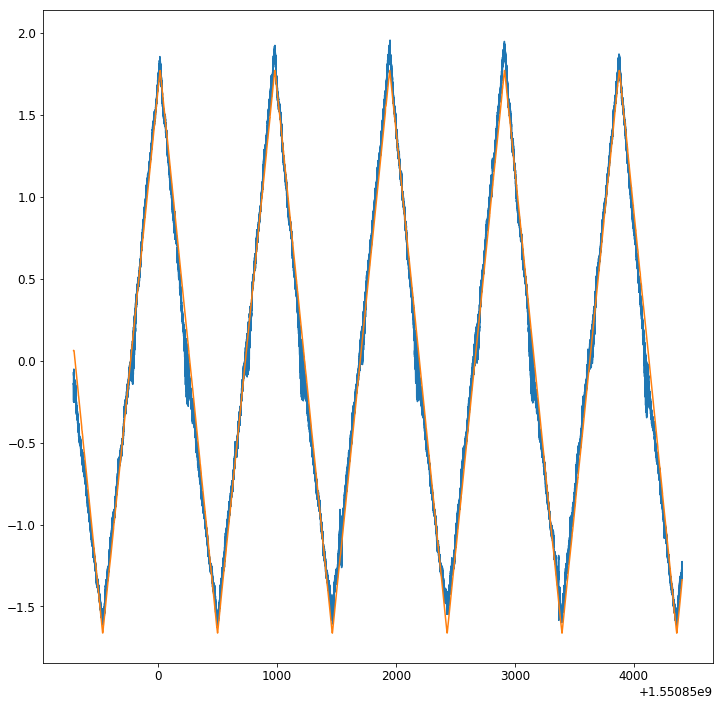

In [281]:
TESNum = 96
data = a.timeline(TES=TESNum)
t_data = a.timeline_timeaxis(axistype='pps')

plot(t_data, (data-np.mean(data))/np.std(data), label='Data')
plot(t_az, (az-np.mean(az))/np.std(az), label='Az')

Let's check the modulation frequency (main peak in data)

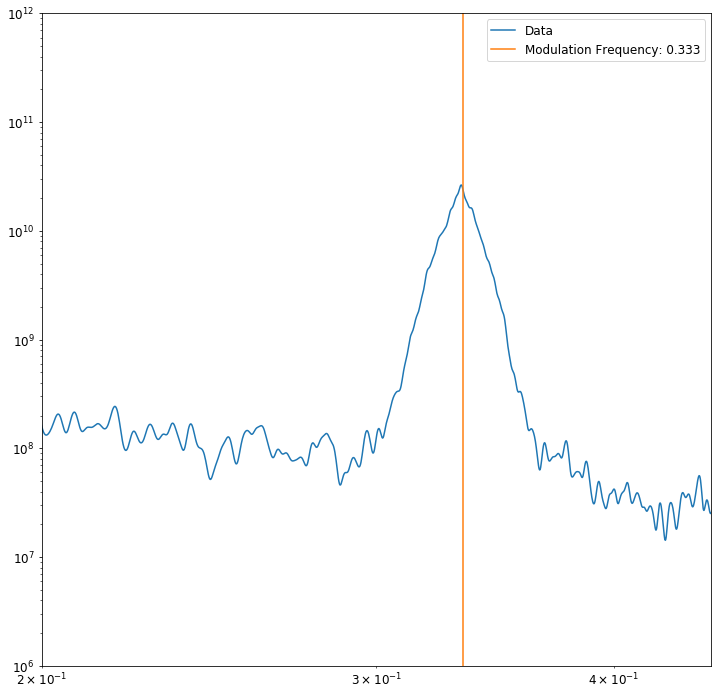

In [282]:
FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), window=mlab.window_hanning)
plot(freq_f, f.gaussian_filter1d(spectrum_f,5),label='Data')
yscale('log')
xscale('log')
xlim(0.2,0.45)
freq_mod = 0.333
plot([freq_mod, freq_mod], [1e6, 1e12], label='Modulation Frequency: {}'.format(freq_mod))
ylim(1e6, 1e12)
legend()

## Simulating CalSrc Data

Here we use the model of the calibration source data (written by Baniele Mennella using the documentation of the source that describes the instricic non linearity of the source). We use this instead of the Calibration Source Data itself that may not always be available. The tricky part here is probably the relative timing...

(4800, 4820)

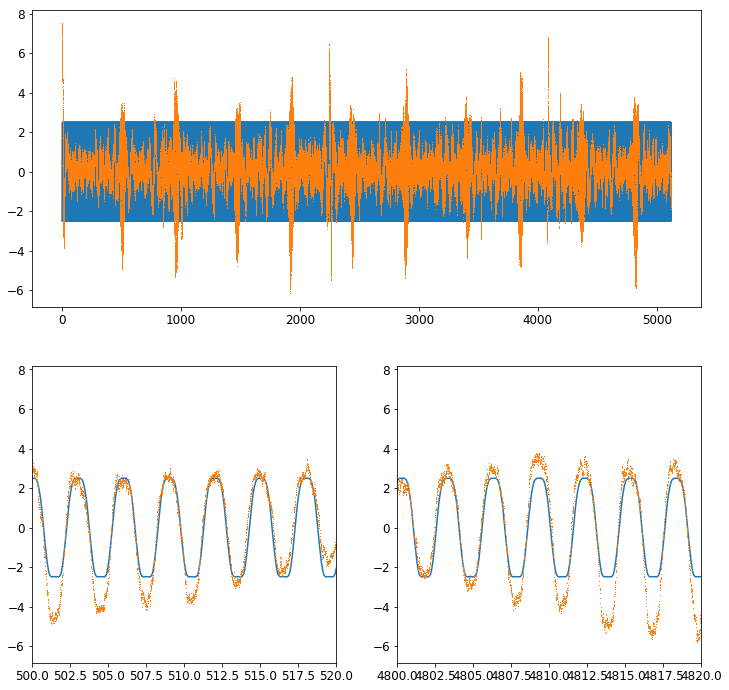

In [286]:
#### Source parameters
src_amp = 5.          # Volts
src_period = 1./0.333 # seconds
src_phase = 0.6        # Radians
src_offset = 2.5      # Volts

#### Source in the data parameters
src_amp_data = 5. 
src_off_data = -2.5

src_pars = np.array([src_amp_data, src_off_data, src_amp, src_period, src_phase, src_offset])
t_src = t_data
data_src = ll.sinesat(t_src, src_pars)


lowcut = 0.03
highcut = FREQ_SAMPLING/2
filt = scsig.butter(5, [lowcut / FREQ_SAMPLING, highcut / FREQ_SAMPLING], btype='bandpass', output='sos')
data_filtered = -scsig.sosfilt(filt, data)

subplot(2,1,1)
plot(t_src-t_data[0], data_src)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered),',')
subplot(2,2,3)
plot(t_src-t_data[0], data_src)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered),',')
xlim(500,520)
subplot(2,2,4)
plot(t_src-t_data[0], data_src)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered),',')
xlim(4800,4820)


In [287]:

def gauss(x,par):
    return par[3]+par[2]*np.exp(-0.5 * (x-par[0])**2 / par[1]**2)


def demodulate_and_rebin(time, data, t_az, az, t_src, src, lowcut, highcut, fmod, nbins, elevation):
    import scipy.signal as scsig
    
    ### Filter Data and Source Signal the same way
    FREQ_SAMPLING = 1./(time[1]-time[0])
    filt = scsig.butter(5, [lowcut / FREQ_SAMPLING, highcut / FREQ_SAMPLING], btype='bandpass', output='sos')
    # Filter Data and change its sign to be in the same as Src
    new_data = -scsig.sosfilt(filt, data)
    # Interpolate Src on data times and filter it
    new_src = scsig.sosfilt(filt, np.interp(time, t_src, src))

    # Make the product for demodulation
    product = new_data * new_src / np.sum(new_src**2)

    # Smooth it over a period
    ppp = 1./fmod
    size_period = int(FREQ_SAMPLING * ppp)+1
    filter_period = np.ones((size_period,))/size_period
    mov_av = np.convolve(product, filter_period, mode='same')
    
    # Rebin this demodulated data as a function of azimuth corrected for elevation
    ang_bin, amp_bin, dang, damp = ft.profile(np.interp(time, t_az, az)*np.cos(np.radians(elevation)), 
                                              mov_av, nbins=nbins,
                                              dispersion=True, plot=False, median=True)
    
    return ang_bin, amp_bin, dang, damp        

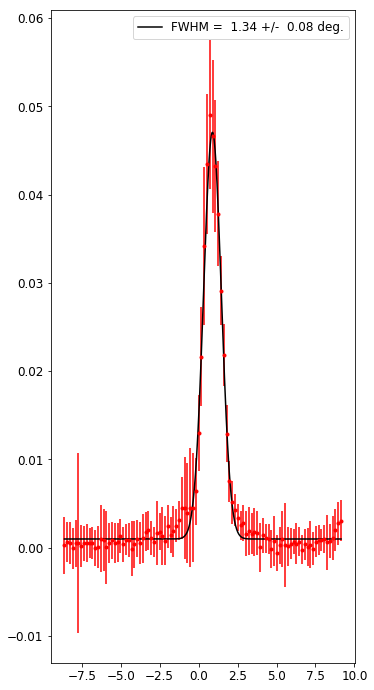

In [288]:
lowcut = 0.1
highcut = 15.
nbins = 100
freq_mod = 0.333
elevation = 50
ang_bin, amp_bin, dang, damp = demodulate_and_rebin(t_data, data, t_az, az, t_src, data_src, 
                                                    lowcut, highcut, freq_mod, nbins, elevation)

### Guess for the peak location
amp_bin_renorm = (amp_bin-np.min(amp_bin))
amp_bin_renorm = amp_bin_renorm / np.sum(amp_bin_renorm)
peak_guess = np.sum(ang_bin * (amp_bin_renorm))
amp_bin_renorm=0
guess = np.array([peak_guess, 1., np.max(amp_bin)-np.min(amp_bin), np.min(amp_bin)])
res = ft.do_minuit(ang_bin, amp_bin, damp, guess, 
               functname=gauss, verbose=False,nohesse=True, force_chi2_ndf=False)


subplot(1,2,2)
errorbar(ang_bin, amp_bin, yerr=damp,fmt='r.')
xxx = np.linspace(np.min(ang_bin), np.max(ang_bin), 1000)
plot(xxx, gauss(xxx, res[1]),'k-',
                label='FWHM = {0:5.2f} +/- {1:5.2f} deg.'.format(2.35*res[1][1], 2.35*res[2][1]))
legend()

In [312]:
#### A spline class to be used for fitting
#### Example:
# npts = 55
# xx = np.random.rand(npts)*10
# yy = 2*xx**3 - 1*xx**2 +7*xx - 1
# dy = np.zeros(npts)+30
# errorbar(xx, yy,yerr=dy, fmt='ro')

# xxx = np.linspace(0,10,1000)
# nx = 10
# myspl = MySpl(xxx,nx)

# guess = guess=np.zeros(myspl.nbspl)
# res = ft.do_minuit(xx, yy, dy, guess, 
#                functname=myspl, verbose=False,nohesse=True, force_chi2_ndf=False)

# plot(xxx, myspl(xxx, res[1]))
class MySpl:
    def __init__(self, xin, nbspl):
        self.xin = xin
        self.nbspl = nbspl
        self.xspl = np.linspace(np.min(self.xin), np.max(self.xin), self.nbspl)
        F=np.zeros((np.size(xin),self.nbspl))
        self.F=F
        for i in np.arange(self.nbspl):
            self.F[:,i]=self.get_spline(self.xin, i)

    def __call__(self, x, pars):
        theF=np.zeros((np.size(x),self.nbspl))
        for i in np.arange(self.nbspl): theF[:,i]=self.get_spline(x,i)
        return(dot(theF,pars))
        
    def get_spline(self, xx, index):
        yspl=zeros(np.size(self.xspl))
        yspl[index]=1.
        tck=interpolate.splrep(self.xspl,yspl)
        yy=interpolate.splev(xx,tck,der=0)
        return(yy)




#### Class to simulate the TOD signal when modulating with the source
#### The main signal will be that of the source (simulated)
#### It is modulated by a slowly varying spline for amplitude, offset and phase 
#### each with a given number of spline nodes
class SimSrcTOD:
    def __init__(self, xin, pars_src, nbspl_amp, nbspl_offset, nbspl_phase):
        self.xin = xin
        self.nbspl_amp = nbspl_amp
        self.nbspl_offset = nbspl_offset
        self.nbspl_phase = nbspl_phase
        ### Splines for each of amplitude, offset and phase
        self.spl_amp = MySpl(xin, nbspl_amp)
        self.spl_offset = MySpl(xin, nbspl_offset)
        self.spl_phase = MySpl(xin, nbspl_phase)
        ### Source parameters: 0=amp, 1=mod_freq, 2=offset
        self.pars_src = pars_src
        
    def amplitude(self, x, pars):
        ### Amplitude function
        pars_amp = pars[0:self.nbspl_amp]
        #print('Amp:',len(pars_amp))
        #print(pars_amp)
        amp = self.spl_amp(x, pars_amp)
        return amp
        
    def offset (self, x, pars):
        ### Offset function
        pars_offset = pars[self.nbspl_amp:self.nbspl_amp+self.nbspl_offset]
        #print('Offset:',len(pars_offset))
        #print(pars_offset)
        offset = self.spl_offset(x, pars_offset)
        return offset
        
    def phase(self, x, pars):
        ### Phase function
        pars_phase = pars[self.nbspl_amp+self.nbspl_offset:self.nbspl_amp+self.nbspl_offset+self.nbspl_phase]
        #print('Phase',len(pars_phase))
        #print(pars_phase)
        phase = self.spl_phase(x, pars_phase)
        return phase
        
    def __call__(self, x, pars):
        #print('')
        #print(pars)
        amp = self.amplitude(x, pars)
        offset = self.offset(x, pars)
        phase = self.phase(x,pars)
        ### Source input signal: 0=amp, 1=mod_freq, 2=offset
        input_src = ll.sim_generator_power(x, self.pars_src[0], self.pars_src[2], self.pars_src[1], phase)-0.5
        
        ### Now modulate with amplitude and offset
        return amp * input_src + offset
        
   

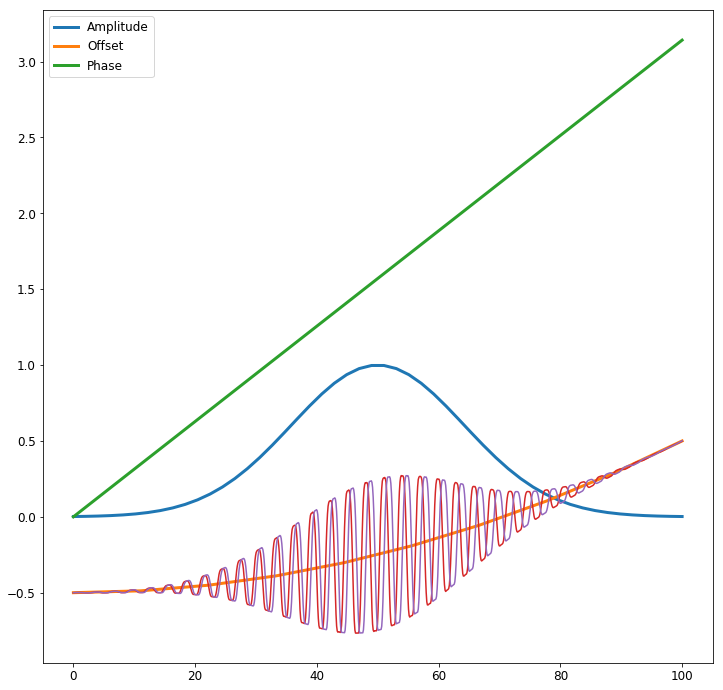

In [313]:
#### Source parameters
src_amp = 5.          # Volts
src_freq = 0.333      # seconds
src_phase = 0.        # Radians
src_offset = 2.5      # Volts
pars_src = np.array([src_amp, src_freq, src_offset])

mini = 0
maxi = 100
xxx = linspace(mini, maxi, 1000)
nbspl_amp = 50
nbspl_offset = 10
nbspl_phase = 4

simsrc = SimSrcTOD(xxx, pars_src, nbspl_amp, nbspl_offset, nbspl_phase)

x_amp = np.linspace(mini, maxi, nbspl_amp)
f_amp = np.exp(-0.5*(x_amp-50.)**2/(2*10**2))

x_offset = np.linspace(mini, maxi, nbspl_offset)
f_offset = x_offset**2/maxi**2-0.5

x_phase = np.linspace(mini, maxi, nbspl_phase)
f_phase = x_phase/maxi*np.pi

pars = np.concatenate((f_amp,f_offset,f_phase))
signal = simsrc(xxx, pars)

pars = np.concatenate((f_amp,f_offset,f_phase*0))
signal_nophase = simsrc(xxx, pars)

clf()
plot(x_amp, f_amp, label='Amplitude',lw=3)
plot(x_offset, f_offset, label='Offset',lw=3)
plot(x_phase, f_phase, label='Phase',lw=3)
plot(xxx, signal)
plot(xxx, signal_nophase)
#plot(xxx, simsrc.offset(xxx,pars)+simsrc.amplitude(xxx,pars)*0.5,'--', label='Off + amp',lw=3)
#plot(xxx, simsrc.phase(xxx,pars),'--', label='Ph',lw=3)
legend()


15626
266
(52939,)
(800048,)
(800048,)
(266,)


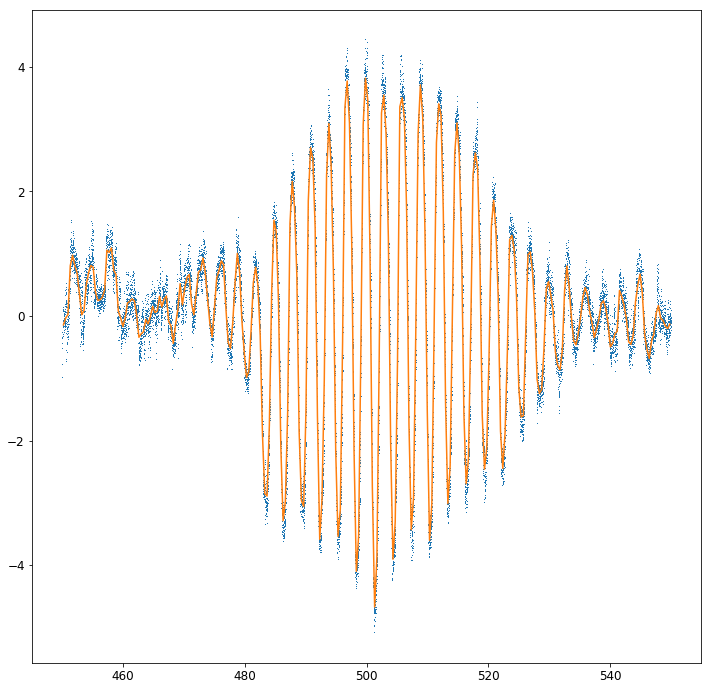

In [314]:
mid = 500
dt = 50
ok_data = np.abs(t_data-t_data[0]-mid) < dt


lowcut = 0.05
highcut = FREQ_SAMPLING/2
filt = scsig.butter(5, [lowcut / FREQ_SAMPLING, highcut / FREQ_SAMPLING], btype='bandpass', output='sos')
data_filtered = -scsig.sosfilt(filt, data)


### We resample the data in bins of xx seconds
x_data_init = t_data[ok_data]-t_data[0]
newdata_init = (data_filtered-np.mean(data_filtered))/np.std(data_filtered)
newdata_init = newdata_init[ok_data]
plot(x_data_init, newdata_init,',')

### new binning ~ 6xmod_freq of the src
fech = freq_mod*8
nbins = int((np.max(x_data_init)-np.min(x_data_init))*fech)
print len(x_data_init)
print nbins
x_data, newdata, dx, dy = ft.profile(x_data_init, newdata_init, range=None, nbins=nbins, plot=False)

plot(x_data, newdata)
new_az = np.interp(x_data, t_az-t_data[0], az)
print t_az.shape
print t_data.shape
print data.shape
print new_az.shape




In [315]:
#### Source parameters
src_amp = 5.          # Volts
src_period = 1./0.333 # seconds
src_phase = 0        # Radians
src_offset = 2.5      # Volts
pars_src = np.array([src_amp, src_freq, src_offset])

nbspl_amp = 20
nbspl_offset = 20
nbspl_phase = 4
simsrc = SimSrcTOD(x_data, pars_src, nbspl_amp, nbspl_offset, nbspl_phase)

guess = np.concatenate((np.ones(nbspl_amp),np.zeros(nbspl_offset),np.zeros(nbspl_phase)))

res = ft.do_minuit(x_data, newdata, np.ones(len(newdata)), guess,
                   functname=simsrc, verbose=False,nohesse=True, force_chi2_ndf=False)


(20, 20, 4)


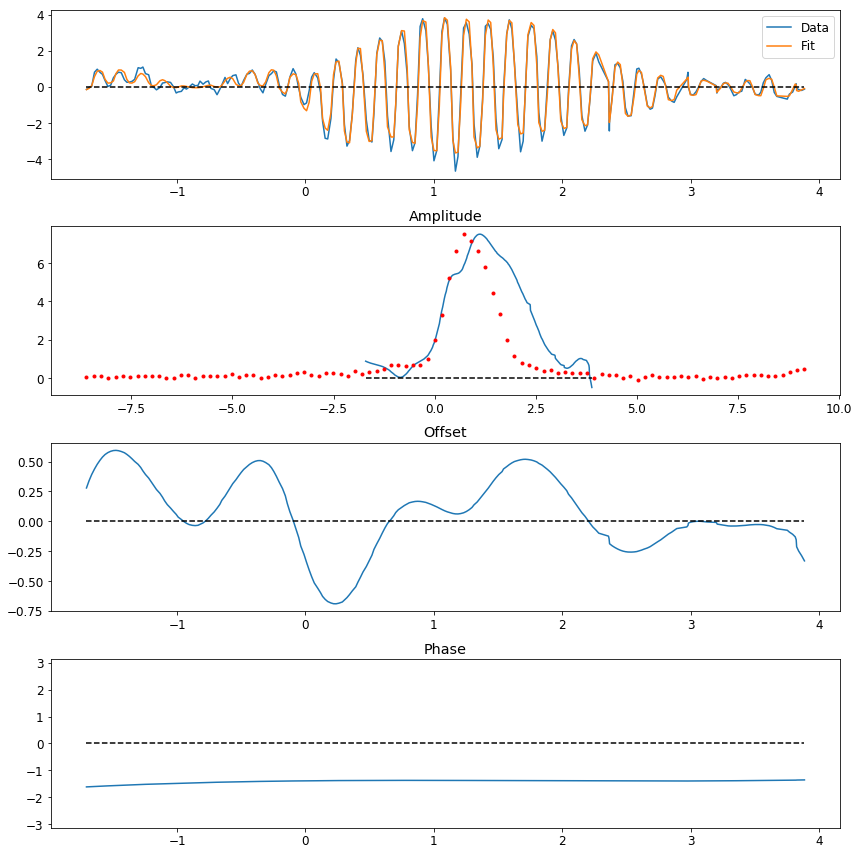

In [316]:
rc('figure',figsize=(12,12))
amplitude = res[1][0:nbspl_amp]
offset = res[1][nbspl_amp:nbspl_amp+nbspl_offset]
phase = res[1][nbspl_amp+nbspl_offset:nbspl_amp+nbspl_offset+nbspl_phase]

print(len(amplitude), len(offset), len(phase))

subplot(4,1,1)
plot(new_az*cos(elevation), newdata, label='Data')
plot(new_az*cos(elevation), simsrc(x_data, res[1]), label='Fit')
plot(new_az*cos(elevation), new_az*0,'k--')
legend()
subplot(4,1,2)
plot(new_az*cos(elevation), simsrc.amplitude(x_data, res[1]))
plot(new_az*cos(elevation), new_az*0,'k--')
errorbar(ang_bin, amp_bin/np.max(amp_bin)*np.max(simsrc.amplitude(x_data, res[1])), yerr=damp,fmt='r.')
title('Amplitude')
subplot(4,1,3)
plot(new_az*cos(elevation), simsrc.offset(x_data, res[1]))
plot(new_az*cos(elevation), new_az*0,'k--')
title('Offset')
subplot(4,1,4)
plot(new_az*cos(elevation), simsrc.phase(x_data, res[1]))
plot(new_az*cos(elevation), new_az*0,'k--')
ylim(-np.pi,np.pi)
title('Phase')
tight_layout()